<a href="https://colab.research.google.com/github/Neulvo/py_yum/blob/master/nsmc_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mecab 설치
!sudo apt-get install g++ openjdk-7-jdk # Install Java 1.7+
!sudo apt-get install python-dev; pip install konlpy     # Python 2.x
!sudo apt-get install python3-dev; pip3 install konlpy   # Python 3.x
!sudo apt-get install curl
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

In [ ]:
!pip install konlpy

In [ ]:
!pip install Mecab

In [ ]:
!pip install gensim

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer 
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Input, layers
from keras.models import load_model
from sklearn.utils import class_weight
from keras.regularizers import l2
from keras.models import load_model

In [ ]:
from konlpy.tag import Okt
from konlpy.tag import Mecab
from gensim.models import Word2Vec

In [ ]:
from keras.callbacks import ModelCheckpoint

In [ ]:
import pickle

# 데이터 불러오기

In [ ]:
train=pd.read_csv('/content/drive/My Drive/data/nsmc/ratings_train.txt',sep='\t')
test=pd.read_csv('/content/drive/My Drive/data/nsmc/ratings_test.txt',sep='\t')
full=pd.read_csv('/content/drive/My Drive/data/nsmc/ratings.txt',sep='\t')

In [ ]:
train.dropna(inplace=True)
test.dropna(inplace=True)
full.dropna(inplace=True)

In [ ]:
train['document'] = train['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test['document'] = test['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

In [ ]:
training_sentences=np.array(train['document'])
training_labels=np.array(train['label'])
testing_sentences=np.array(test['document'])
testing_labels=np.array(test['label'])
full_sentences=np.array(full['document'])
full_labels=np.array(full['label'])

In [ ]:
vocab_size = 10000
max_length= 100
trunc_type = 'pre'
padding_type = 'pre'
oov_tok = '<OOV>'

# FastText

In [ ]:
# !pip install fasttext

In [ ]:
# import fasttext.util
# fasttext.util.download_model('ko', if_exists='ignore')
# ft = fasttext.load_model('cc.ko.300.bin')

In [ ]:
import subprocess

with open(r"/content/drive/My Drive/data/nsmc/wiki.ko.vec", encoding='utf-8') as f:
    wiki = f.readlines()

In [ ]:
embedding_dict = dict()

for line in wiki:
    word_vector = line.split()
    word = word_vector[0]
    word_vector_arr = np.asarray(word_vector[1:], dtype='float32') 
    embedding_dict[word] = word_vector_arr
# f.close()
print('%s개의 Embedding vector가 있습니다.' % len(embedding_dict))

879130개의 Embedding vector가 있습니다.


# Base
split by (' ')

## Base_contextual

### 학습 포맷 맞추기

In [ ]:
tokenizer=Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index=tokenizer.word_index 

In [ ]:
def padding_maker(train_sentence, test_sentence):

  training_sequences= tokenizer.texts_to_sequences(train_sentence)
  training_padded=pad_sequences(training_sequences, maxlen=max_length,padding=padding_type, truncating=trunc_type)
  testing_sequences= tokenizer.texts_to_sequences(test_sentence)
  testing_padded=pad_sequences(testing_sequences, maxlen=max_length,padding=padding_type, truncating=trunc_type)
  
  training_padded =np.array(training_padded)
  testing_padded =np.array(testing_padded)
  return training_padded, testing_padded

In [ ]:
training_padded, testing_padded= padding_maker(training_sentences,testing_sentences)

In [ ]:
training_labels =np.array(training_labels)
testing_labels =np.array(testing_labels)

### CNN 모델

In [ ]:
# Kim Yoon CNN
vocab_size = len(word_index) + 1
embedding_dim = 300
max_len = max(len(x) for x in training_padded)
class_weights = class_weight.compute_class_weight('balanced', np.unique(training_labels), training_labels)
class_weights_d = dict(enumerate(class_weights))

sequence_input = Input(shape=(max_len,), dtype='int32')

embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                            embedding_dim,
                                            input_length=max_len,
                                            trainable=False)

embedded_sequences = embedding_layer(sequence_input)

convs = []
filter_sizes = [3,4,5]

for fsz in filter_sizes:
    x = layers.Conv1D(128, fsz, activation='relu',padding='same',kernel_regularizer=l2(1e-3))(embedded_sequences)
    x = layers.MaxPooling1D()(x)
    convs.append(x)
    
x = layers.Concatenate(axis=-1)(convs)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation='sigmoid')(x)


### 컴파일 및 피팅

In [ ]:
model_base = keras.models.Model(sequence_input, output)
model_base.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_base.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 300)     88893600    input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 100, 128)     115328      embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 100, 128)     153728      embedding[0][0]                  
_______________________________________________________________________________________

In [ ]:
callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0005, patience=1, verbose=0, mode='auto')
# Fit model
history_base = model_base.fit(training_padded, training_labels,
                    class_weight = class_weights_d,
                    epochs=10,
                    callbacks=[callback],
                    verbose=True,
                    validation_data=(testing_padded, testing_labels),
                    batch_size=50)
loss, accuracy = model_base.evaluate(training_padded, training_labels, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_base.evaluate(testing_padded, testing_labels, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/10
3000/3000 [==============================] - 22s 7ms/step - loss: 0.6568 - accuracy: 0.6394 - val_loss: 0.6034 - val_accuracy: 0.6920
Epoch 2/10
3000/3000 [==============================] - 22s 7ms/step - loss: 0.5731 - accuracy: 0.7235 - val_loss: 0.5611 - val_accuracy: 0.7332
Epoch 3/10
3000/3000 [==============================] - 22s 7ms/step - loss: 0.5445 - accuracy: 0.7451 - val_loss: 0.5492 - val_accuracy: 0.7421
Epoch 4/10
3000/3000 [==============================] - 22s 7ms/step - loss: 0.5322 - accuracy: 0.7546 - val_loss: 0.5484 - val_accuracy: 0.7428
Epoch 5/10
3000/3000 [==============================] - 22s 7ms/step - loss: 0.5250 - accuracy: 0.7595 - val_loss: 0.5437 - val_accuracy: 0.7430
Epoch 6/10
4688/4688 [==============================] - 15s 3ms/step - loss: 0.4831 - accuracy: 0.7827
Training Accuracy: 0.7827
Testing Accuracy:  0.7495


### ACC, LOSS 그래프

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

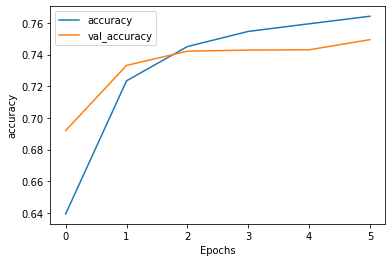

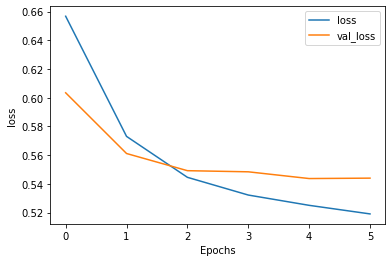

In [ ]:
plot_graphs(history_base, 'accuracy')
plot_graphs(history_base, 'loss')

### 예측

In [ ]:
sentence = ['영화 너무 재밌더라.', '영화 개노잼. 다신 안 봐.']
sequence = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequence, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model_base.predict(padded).round(2))

[[0.46]
 [0.26]]


## Base_FastText

In [ ]:
# 임베딩 메트릭스
embedding_matrix = np.zeros((vocab_size , embedding_dim))
# 단어 집합 크기의 행과 100개의 열을 가지는 행렬 생성. 값은 전부 0으로 채워진다.
np.shape(embedding_matrix)
out_index = 0
for word, i in word_index.items(): # 훈련 데이터의 단어 집합에서 단어를 1개씩 꺼내온다.
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        out_index += 1

print(out_index)

218695


### CNN 모델

In [ ]:
# Kim Yoon CNN
vocab_size = len(word_index) + 1
embedding_dim = 300
max_len = max(len(x) for x in training_padded)
class_weights = class_weight.compute_class_weight('balanced', np.unique(training_labels), training_labels)
class_weights_d = dict(enumerate(class_weights))

sequence_input = Input(shape=(max_len,), dtype='int32')

embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                            embedding_dim,
                                            weights=[embedding_matrix],
                                            input_length=max_len,
                                            trainable=False)

embedded_sequences = embedding_layer(sequence_input)

convs = []
filter_sizes = [3,4,5]

for fsz in filter_sizes:
    x = layers.Conv1D(128, fsz, activation='relu',padding='same',kernel_regularizer=l2(1e-3))(embedded_sequences)
    x = layers.MaxPooling1D()(x)
    convs.append(x)
    
x = layers.Concatenate(axis=-1)(convs)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation='sigmoid')(x)


### 컴파일 및 피팅

In [ ]:
model_base_ff = keras.models.Model(sequence_input, output)
model_base_ff.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_base_ff.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 300)     88893600    input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 100, 128)     115328      embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 100, 128)     153728      embedding_1[0][0]                
_______________________________________________________________________________________

In [ ]:
callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0005, patience=1, verbose=0, mode='auto')
# Fit model
history_base_ff = model_base_ff.fit(training_padded, training_labels,
                    class_weight = class_weights_d,
                    epochs=10,
                    callbacks=[callback],
                    verbose=True,
                    validation_data=(testing_padded, testing_labels),
                    batch_size=50)
loss, accuracy = model_base_ff.evaluate(training_padded, training_labels, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_base_ff.evaluate(testing_padded, testing_labels, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/10
3000/3000 [==============================] - 22s 7ms/step - loss: 0.5838 - accuracy: 0.7167 - val_loss: 0.5450 - val_accuracy: 0.7302
Epoch 2/10
3000/3000 [==============================] - 22s 7ms/step - loss: 0.5357 - accuracy: 0.7389 - val_loss: 0.5256 - val_accuracy: 0.7398
Epoch 3/10
4688/4688 [==============================] - 15s 3ms/step - loss: 0.5069 - accuracy: 0.7505
Training Accuracy: 0.7505
Testing Accuracy:  0.7374


### ACC, LOSS 그래프

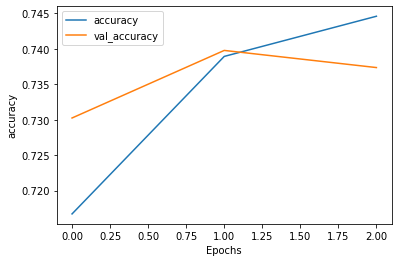

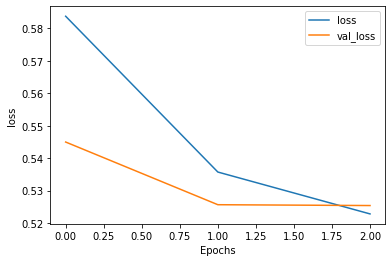

In [ ]:
plot_graphs(history_base_ff, 'accuracy')
plot_graphs(history_base_ff, 'loss')

### 예측

In [ ]:
sentence = ['영화 너무 재밌더라.', '영화 개노잼. 다신 안 봐.']
sequence = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequence, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model_base_ff.predict(padded).round(2))

[[0.28]
 [0.29]]


## Base_Word2Vec

In [ ]:
token_list=[tokens.split() for tokens in full_sentences.tolist()]

In [ ]:
word2vec = Word2Vec(
    sentences = token_list,
    size = embedding_dim,
    alpha = 0.025,
    min_count = 1,
    window=8,
    sample = 0.001,
    sg = 1,
    iter = 10
)

In [ ]:
# 임베딩 메트릭스
embedding_matrix = np.zeros((vocab_size , embedding_dim))
# 단어 집합 크기의 행과 100개의 열을 가지는 행렬 생성. 값은 전부 0으로 채워진다.
np.shape(embedding_matrix)
out_index = 0
for word, i in word_index.items(): # 훈련 데이터의 단어 집합에서 단어를 1개씩 꺼내온다.
  try:
    embedding_vector = word2vec.wv.__getitem__(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        out_index += 1
  except:
    out_index+=1

print(out_index)

54069


### CNN 모델

In [ ]:
# Kim Yoon CNN
vocab_size = len(word_index) + 1
embedding_dim = 300
max_len = max(len(x) for x in training_padded)
class_weights = class_weight.compute_class_weight('balanced', np.unique(training_labels), training_labels)
class_weights_d = dict(enumerate(class_weights))

sequence_input = Input(shape=(max_len,), dtype='int32')

embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                            embedding_dim,
                                            weights=[embedding_matrix],
                                            input_length=max_len,
                                            trainable=False)

embedded_sequences = embedding_layer(sequence_input)

convs = []
filter_sizes = [3,4,5]

for fsz in filter_sizes:
    x = layers.Conv1D(128, fsz, activation='relu',padding='same',kernel_regularizer=l2(1e-3))(embedded_sequences)
    x = layers.MaxPooling1D()(x)
    convs.append(x)
    
x = layers.Concatenate(axis=-1)(convs)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation='sigmoid')(x)


### 컴파일 및 피팅

In [ ]:
model_base_ff = keras.models.Model(sequence_input, output)
model_base_ff.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_base_ff.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 100, 300)     88893600    input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 100, 128)     115328      embedding_3[0][0]                
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 100, 128)     153728      embedding_3[0][0]                
_______________________________________________________________________________________

In [ ]:
callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0005, patience=1, verbose=0, mode='auto')
# Fit model
history_base_ff = model_base_ff.fit(training_padded, training_labels,
                    class_weight = class_weights_d,
                    epochs=10,
                    callbacks=[callback],
                    verbose=True,
                    validation_data=(testing_padded, testing_labels),
                    batch_size=50)
loss, accuracy = model_base_ff.evaluate(training_padded, training_labels, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_base_ff.evaluate(testing_padded, testing_labels, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/10
3000/3000 [==============================] - 22s 7ms/step - loss: 0.5696 - accuracy: 0.7351 - val_loss: 0.5324 - val_accuracy: 0.7447
Epoch 2/10
3000/3000 [==============================] - 22s 7ms/step - loss: 0.5201 - accuracy: 0.7472 - val_loss: 0.5105 - val_accuracy: 0.7482
Epoch 3/10
4688/4688 [==============================] - 15s 3ms/step - loss: 0.4963 - accuracy: 0.7593
Training Accuracy: 0.7593
Testing Accuracy:  0.7478


### ACC, LOSS 그래프

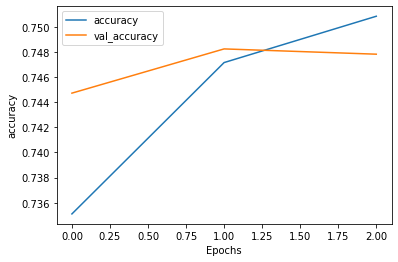

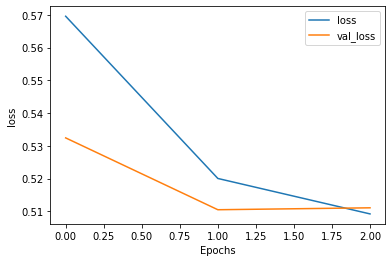

In [ ]:
plot_graphs(history_base_ff, 'accuracy')
plot_graphs(history_base_ff, 'loss')

### 예측

In [ ]:
sentence = ['영화 너무 재밌더라.', '영화 개노잼. 다신 안 봐.']
sequence = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequence, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model_base_ff.predict(padded).round(2))

[[0.42]
 [0.1 ]]


# OKT
tokenized by okt

## OKT_contextual

### 학습 포맷 맞추기

In [ ]:
okt=Okt()

In [ ]:
def okt_nizer(base_sentence):
  okt_sentence=[]
  for sentence in base_sentence:
    pos_tag=okt.pos(sentence)
    tok_sentence=[]
    for token, pos in pos_tag:
      if pos[0] in ['N','V']:
        tok_sentence.append(token)
    okt_sentence.append(' '.join(tok_sentence))
  okt_sentence=np.array(okt_sentence)
  return okt_sentence

In [ ]:
okt_training=okt_nizer(training_sentences)
okt_testing=okt_nizer(testing_sentences)

In [ ]:
tokenizer=Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(okt_training)
okt_word_index=tokenizer.word_index 

In [ ]:
okt_training_padded, okt_testing_padded = padding_maker(okt_training,okt_testing)

### CNN 모델

In [ ]:
# Kim Yoon CNN
vocab_size = len(okt_word_index) +1
embedding_dim = 300
max_len = max(len(x) for x in okt_training_padded)
class_weights = class_weight.compute_class_weight('balanced', np.unique(training_labels), training_labels)
class_weights_d = dict(enumerate(class_weights))

sequence_input = Input(shape=(max_len,), dtype='int32')

embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                            embedding_dim,
                                            input_length=max_len,
                                            trainable=False)

embedded_sequences = embedding_layer(sequence_input)

convs = []
filter_sizes = [3,4,5]

for fsz in filter_sizes:
    x = layers.Conv1D(128, fsz, activation='relu',padding='same',kernel_regularizer=l2(1e-3))(embedded_sequences)
    x = layers.MaxPooling1D()(x)
    convs.append(x)
    
x = layers.Concatenate(axis=-1)(convs)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation='sigmoid')(x)

### 컴파일 및 피팅

In [ ]:
model_okt_base = keras.models.Model(sequence_input, output)
model_okt_base.compile(loss='binary_crossentropy',
                       optimizer='adam',
                       metrics=['accuracy'])

model_okt_base.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 100, 300)     88893600    input_5[0][0]                    
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 100, 128)     115328      embedding_4[0][0]                
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 100, 128)     153728      embedding_4[0][0]                
_______________________________________________________________________________________

In [ ]:
callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0005, patience=1, verbose=0, mode='auto')
# Fit model
history_okt_base = model_okt_base.fit(okt_training_padded, training_labels,
                    class_weight = class_weights_d,
                    epochs=10,
                    callbacks=[callback],
                    verbose=True,
                    validation_data=(okt_testing_padded, testing_labels),
                    batch_size=50)
loss, accuracy = model_okt_base.evaluate(okt_training_padded, training_labels, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_okt_base.evaluate(okt_testing_padded, testing_labels, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/10
3000/3000 [==============================] - 22s 7ms/step - loss: 0.6292 - accuracy: 0.6853 - val_loss: 0.5796 - val_accuracy: 0.7349
Epoch 2/10
3000/3000 [==============================] - 22s 7ms/step - loss: 0.5664 - accuracy: 0.7470 - val_loss: 0.5661 - val_accuracy: 0.7450
Epoch 3/10
3000/3000 [==============================] - 22s 7ms/step - loss: 0.5433 - accuracy: 0.7649 - val_loss: 0.5527 - val_accuracy: 0.7528
Epoch 4/10
3000/3000 [==============================] - 22s 7ms/step - loss: 0.5306 - accuracy: 0.7741 - val_loss: 0.5506 - val_accuracy: 0.7486
Epoch 5/10
4688/4688 [==============================] - 15s 3ms/step - loss: 0.4911 - accuracy: 0.7946
Training Accuracy: 0.7946
Testing Accuracy:  0.7485


### ACC, LOSS 그래프

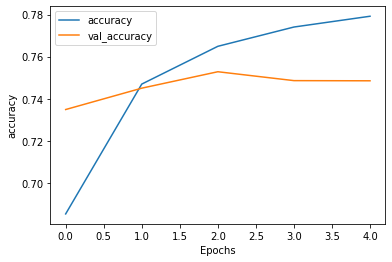

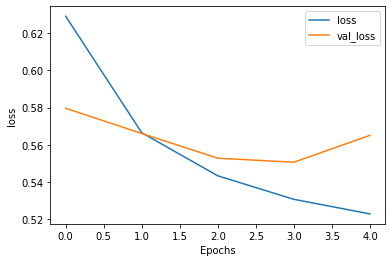

In [ ]:
plot_graphs(history_okt_base, 'accuracy')
plot_graphs(history_okt_base, 'loss')

### 예측

In [ ]:
sentence = ['영화 너무 재밌더라.', '영화 개노잼. 다신 안 봐.']
sequence = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequence, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model_okt_base.predict(padded).round(2))

[[0.49]
 [0.15]]


## OKT_FastText

In [ ]:
# 임베딩 메트릭스
embedding_matrix = np.zeros((vocab_size , embedding_dim))
# 단어 집합 크기의 행과 100개의 열을 가지는 행렬 생성. 값은 전부 0으로 채워진다.
np.shape(embedding_matrix)
out_index = 0
for word, i in okt_word_index.items(): # 훈련 데이터의 단어 집합에서 단어를 1개씩 꺼내온다.
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        out_index += 1

print(out_index)

37633


### CNN 모델

In [ ]:
# Kim Yoon CNN
vocab_size = len(okt_word_index) + 1
embedding_dim = 300
max_len = max(len(x) for x in okt_training_padded)
class_weights = class_weight.compute_class_weight('balanced', np.unique(training_labels), training_labels)
class_weights_d = dict(enumerate(class_weights))

sequence_input = Input(shape=(max_len,), dtype='int32')

embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                            embedding_dim,
                                            weights=[embedding_matrix],
                                            input_length=max_len,
                                            trainable=False)

embedded_sequences = embedding_layer(sequence_input)

convs = []
filter_sizes = [3,4,5]

for fsz in filter_sizes:
    x = layers.Conv1D(128, fsz, activation='relu',padding='same',kernel_regularizer=l2(1e-3))(embedded_sequences)
    x = layers.MaxPooling1D()(x)
    convs.append(x)
    
x = layers.Concatenate(axis=-1)(convs)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation='sigmoid')(x)


### 컴파일 및 피팅

In [ ]:
model_okt_ff = keras.models.Model(sequence_input, output)
model_okt_ff.compile(loss='binary_crossentropy',
                       optimizer='adam',
                       metrics=['accuracy'])

model_okt_ff.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 100, 300)     88893600    input_6[0][0]                    
__________________________________________________________________________________________________
conv1d_12 (Conv1D)              (None, 100, 128)     115328      embedding_5[0][0]                
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, 100, 128)     153728      embedding_5[0][0]                
_______________________________________________________________________________________

In [ ]:
callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0005, patience=1, verbose=0, mode='auto')
# Fit model
history_okt_ff = model_okt_ff.fit(okt_training_padded, training_labels,
                    class_weight = class_weights_d,
                    epochs=10,
                    callbacks=[callback],
                    verbose=True,
                    validation_data=(okt_testing_padded, testing_labels),
                    batch_size=50)
loss, accuracy = model_okt_ff.evaluate(okt_training_padded, training_labels, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_okt_ff.evaluate(okt_testing_padded, testing_labels, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/10
3000/3000 [==============================] - 22s 7ms/step - loss: 0.5971 - accuracy: 0.7280 - val_loss: 0.5513 - val_accuracy: 0.7438
Epoch 2/10
3000/3000 [==============================] - 22s 7ms/step - loss: 0.5392 - accuracy: 0.7531 - val_loss: 0.5320 - val_accuracy: 0.7545
Epoch 3/10
3000/3000 [==============================] - 22s 7ms/step - loss: 0.5262 - accuracy: 0.7574 - val_loss: 0.5278 - val_accuracy: 0.7541
Epoch 4/10
4688/4688 [==============================] - 15s 3ms/step - loss: 0.4957 - accuracy: 0.7742
Training Accuracy: 0.7742
Testing Accuracy:  0.7543


### ACC, LOSS 그래프

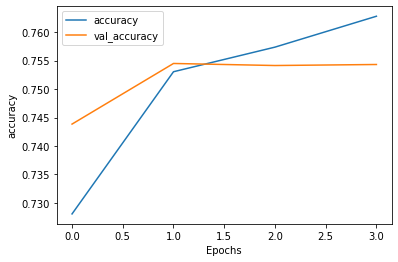

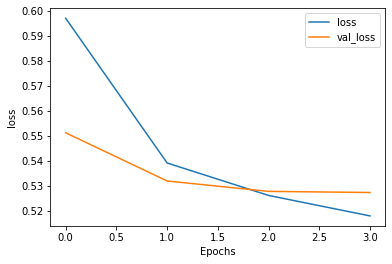

In [ ]:
plot_graphs(history_okt_ff, 'accuracy')
plot_graphs(history_okt_ff, 'loss')

### 예측

In [ ]:
sentence = ['영화 너무 재밌더라.', '영화 개노잼. 다신 안 봐.']
sequence = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequence, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model_okt_ff.predict(padded).round(2))

[[0.56]
 [0.5 ]]


## OKT_Word2Vec

In [ ]:
token_list=[]
for sentence in full_sentences:
  pos_tag=okt.pos(sentence)
  tok_sentence=[]
  for token, pos in pos_tag:
    if pos[0] in ['N','V']:
      tok_sentence.append(token)
  token_list.append(tok_sentence)

In [ ]:
word2vec = Word2Vec(
    sentences = token_list,
    size = embedding_dim,
    alpha = 0.025,
    min_count = 1,
    window=8,
    sample = 0.001,
    sg = 1,
    iter = 10
)

In [ ]:
# 임베딩 메트릭스
embedding_matrix = np.zeros((vocab_size , embedding_dim))
# 단어 집합 크기의 행과 100개의 열을 가지는 행렬 생성. 값은 전부 0으로 채워진다.
np.shape(embedding_matrix)
out_index = 0
for word, i in okt_word_index.items(): # 훈련 데이터의 단어 집합에서 단어를 1개씩 꺼내온다.
  try:
    embedding_vector = word2vec.wv.__getitem__(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        out_index += 1
  except:
    out_index+=1

print(out_index)

250243


### CNN 모델

In [ ]:
# Kim Yoon CNN
vocab_size = len(okt_word_index) + 1
embedding_dim = 300
max_len = max(len(x) for x in training_padded)
class_weights = class_weight.compute_class_weight('balanced', np.unique(training_labels), training_labels)
class_weights_d = dict(enumerate(class_weights))

sequence_input = Input(shape=(max_len,), dtype='int32')

embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                            embedding_dim,
                                            weights=[embedding_matrix],
                                            input_length=max_len,
                                            trainable=False)

embedded_sequences = embedding_layer(sequence_input)

convs = []
filter_sizes = [3,4,5]

for fsz in filter_sizes:
    x = layers.Conv1D(128, fsz, activation='relu',padding='same',kernel_regularizer=l2(1e-3))(embedded_sequences)
    x = layers.MaxPooling1D()(x)
    convs.append(x)
    
x = layers.Concatenate(axis=-1)(convs)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation='sigmoid')(x)


### 컴파일 및 피팅

In [ ]:
model_okt_w2 = keras.models.Model(sequence_input, output)
model_okt_w2.compile(loss='binary_crossentropy',
                       optimizer='adam',
                       metrics=['accuracy'])

model_okt_w2.summary()

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 100, 300)     88893600    input_8[0][0]                    
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 100, 128)     115328      embedding_7[0][0]                
__________________________________________________________________________________________________
conv1d_19 (Conv1D)              (None, 100, 128)     153728      embedding_7[0][0]                
______________________________________________________________________________________

In [ ]:
callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0005, patience=1, verbose=0, mode='auto')
# Fit model
history_okt_w2 = model_okt_w2.fit(okt_training_padded, training_labels,
                    class_weight = class_weights_d,
                    epochs=10,
                    callbacks=[callback],
                    verbose=True,
                    validation_data=(okt_testing_padded, testing_labels),
                    batch_size=50)
loss, accuracy = model_okt_w2.evaluate(okt_training_padded, training_labels, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_okt_w2.evaluate(okt_testing_padded, testing_labels, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/10
3000/3000 [==============================] - 22s 7ms/step - loss: 0.6414 - accuracy: 0.6608 - val_loss: 0.6010 - val_accuracy: 0.6774
Epoch 2/10
3000/3000 [==============================] - 22s 7ms/step - loss: 0.5965 - accuracy: 0.6832 - val_loss: 0.5906 - val_accuracy: 0.6796
Epoch 3/10
3000/3000 [==============================] - 22s 7ms/step - loss: 0.5857 - accuracy: 0.6879 - val_loss: 0.5869 - val_accuracy: 0.6860
Epoch 4/10
3000/3000 [==============================] - 22s 7ms/step - loss: 0.5796 - accuracy: 0.6918 - val_loss: 0.5855 - val_accuracy: 0.6870
Epoch 5/10
3000/3000 [==============================] - 21s 7ms/step - loss: 0.5771 - accuracy: 0.6941 - val_loss: 0.5803 - val_accuracy: 0.6864
Epoch 6/10
4688/4688 [==============================] - 15s 3ms/step - loss: 0.5676 - accuracy: 0.6992
Training Accuracy: 0.6992
Testing Accuracy:  0.6863


### ACC, LOSS 그래프

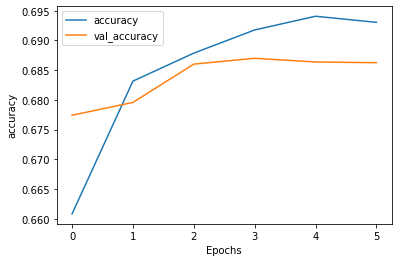

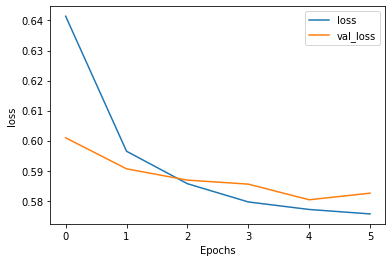

In [ ]:
plot_graphs(history_okt_w2, 'accuracy')
plot_graphs(history_okt_w2, 'loss')

### 예측

In [ ]:
sentence = ['영화 너무 재밌더라.', '영화 개노잼. 다신 안 봐.']
sequence = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequence, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model_okt_w2.predict(padded).round(2))

[[0.5 ]
 [0.63]]


# Mecab
tokenized by mecab

## Mecab_contextual

### 학습 포맷 맞추기

In [ ]:
mecab=Mecab()

In [ ]:
def mecab_nizer(base_sentence):
  stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
  mecab_sentence=[]
  for sentence in base_sentence:
    pos_tag=mecab.pos(sentence)
    tok_sentence=[]
    for token, pos in pos_tag:
      if token not in stopwords:
        tok_sentence.append(token)
    mecab_sentence.append(' '.join(tok_sentence))
  mecab_sentence=np.array(mecab_sentence)
  return mecab_sentence

In [ ]:
mecab_training=mecab_nizer(training_sentences)
mecab_testing=mecab_nizer(testing_sentences)

In [ ]:
tokenizer=Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(mecab_training)
mecab_word_index=tokenizer.word_index 

In [ ]:
mecab_training_padded, mecab_testing_padded = padding_maker(mecab_training,mecab_testing)

In [ ]:
vocab_size = len(mecab_word_index) + 1
max_len = max(len(x) for x in mecab_training_padded)
embedding_dim = 300
vocab_size = len(mecab_word_index) + 1

### CNN 모델

In [ ]:
# Kim Yoon CNN
vocab_size = len(mecab_word_index) + 1
embedding_dim = 300
max_len = max(len(x) for x in mecab_training_padded)
class_weights = class_weight.compute_class_weight('balanced', np.unique(training_labels), training_labels)
class_weights_d = dict(enumerate(class_weights))

sequence_input = Input(shape=(max_len,), dtype='int32')

embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                            embedding_dim,
                                            input_length=max_len,
                                            trainable=False)

embedded_sequences = embedding_layer(sequence_input)

convs = []
filter_sizes = [3,4,5]

for fsz in filter_sizes:
    x = layers.Conv1D(128, fsz, activation='relu',padding='same',kernel_regularizer=l2(1e-3))(embedded_sequences)
    x = layers.MaxPooling1D()(x)
    convs.append(x)
    
x = layers.Concatenate(axis=-1)(convs)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation='sigmoid')(x)

### 컴파일 및 피팅

In [ ]:
model_mecab_base = keras.models.Model(sequence_input, output)
model_mecab_base.compile(loss='binary_crossentropy',
                       optimizer='adam',
                       metrics=['accuracy'])

model_mecab_base.summary()

Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 100, 300)     14984400    input_7[0][0]                    
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 100, 128)     115328      embedding_6[0][0]                
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 100, 128)     153728      embedding_6[0][0]                
______________________________________________________________________________________

In [ ]:
callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0005, patience=1, verbose=0, mode='auto')
# Fit model
history_mecab_base = model_mecab_base.fit(mecab_training_padded, training_labels,
                    class_weight = class_weights_d,
                    epochs=10,
                    callbacks=[callback],
                    verbose=True,
                    validation_data=(mecab_testing_padded, testing_labels),
                    batch_size=50)
loss, accuracy = model_mecab_base.evaluate(mecab_training_padded, training_labels, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_mecab_base.evaluate(mecab_testing_padded, testing_labels, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/10
3000/3000 [==============================] - 22s 7ms/step - loss: 0.5622 - accuracy: 0.7611 - val_loss: 0.5082 - val_accuracy: 0.8019
Epoch 2/10
3000/3000 [==============================] - 22s 7ms/step - loss: 0.4895 - accuracy: 0.8155 - val_loss: 0.4817 - val_accuracy: 0.8146
Epoch 3/10
3000/3000 [==============================] - 22s 7ms/step - loss: 0.4601 - accuracy: 0.8294 - val_loss: 0.4690 - val_accuracy: 0.8170
Epoch 4/10
3000/3000 [==============================] - 22s 7ms/step - loss: 0.4450 - accuracy: 0.8342 - val_loss: 0.4592 - val_accuracy: 0.8223
Epoch 5/10
4688/4688 [==============================] - 15s 3ms/step - loss: 0.4035 - accuracy: 0.8540
Training Accuracy: 0.8540
Testing Accuracy:  0.8180


### ACC, LOSS 그래프

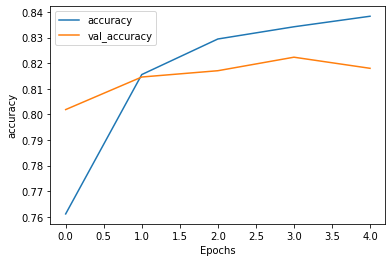

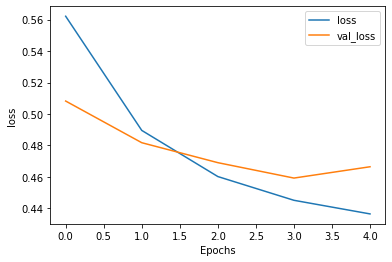

In [ ]:
plot_graphs(history_mecab_base, 'accuracy')
plot_graphs(history_mecab_base, 'loss')

### 예측

In [ ]:
sentence = ['영화 너무 재밌더라.', '영화 개노잼. 다신 안 봐.']
sequence = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequence, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model_mecab_base.predict(padded).round(2))

[[0.26]
 [0.08]]


### LSTM model 

In [ ]:
# Kim Yoon CNN
vocab_size = len(mecab_word_index) + 1
embedding_dim = 300
max_len = max(len(x) for x in mecab_training_padded)
class_weights = class_weight.compute_class_weight('balanced', np.unique(training_labels), training_labels)
class_weights_d = dict(enumerate(class_weights))

sequence_input = Input(shape=(max_len,), dtype='int32')

embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                            embedding_dim,
                                            input_length=max_len,
                                            trainable=False)

embedded_sequences = embedding_layer(sequence_input)

convs = []
filter_sizes = [3,4,5]

x =layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(embedded_sequences)
x =layers.Bidirectional(tf.keras.layers.LSTM(128))(x)
x =layers.Dense(64, activation='relu')(x)
x =layers.Dropout(0.2)(x)
output = layers.Dense(1, activation='sigmoid')(x)

### 컴파일 및 피팅

In [ ]:
mecab_lstm_base = keras.models.Model(sequence_input, output)
mecab_lstm_base.compile(loss='binary_crossentropy',
                       optimizer='adam',
                       metrics=['accuracy'])

mecab_lstm_base.summary()

Model: "functional_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 100, 300)          14984400  
_________________________________________________________________
bidirectional_8 (Bidirection (None, 100, 256)          439296    
_________________________________________________________________
bidirectional_9 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense_14 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)               

In [ ]:
callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0005, patience=1, verbose=0, mode='auto')
mc = ModelCheckpoint('/content/drive/My Drive/data/nsmc/lstm_best', monitor='val_loss', mode='min', save_best_only=True)

# Fit model
history_lstm_base = mecab_lstm_base.fit(mecab_training_padded, training_labels,
                    class_weight = class_weights_d,
                    epochs=10,
                    callbacks=[callback,mc],
                    verbose=True,
                    validation_data=(mecab_testing_padded, testing_labels),
                    batch_size=50)
loss, accuracy = mecab_lstm_base.evaluate(mecab_training_padded, training_labels, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = mecab_lstm_base.evaluate(mecab_testing_padded, testing_labels, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/10
3000/3000 [==============================] - 112s 37ms/step - loss: 0.5246 - accuracy: 0.7266 - val_loss: 0.4609 - val_accuracy: 0.7688
Epoch 2/10
3000/3000 [==============================] - 111s 37ms/step - loss: 0.4328 - accuracy: 0.7901 - val_loss: 0.4151 - val_accuracy: 0.7985
Epoch 3/10
3000/3000 [==============================] - 111s 37ms/step - loss: 0.3943 - accuracy: 0.8137 - val_loss: 0.3972 - val_accuracy: 0.8101
Epoch 4/10
3000/3000 [==============================] - 110s 37ms/step - loss: 0.3680 - accuracy: 0.8293 - val_loss: 0.3829 - val_accuracy: 0.8216
Epoch 5/10
4688/4688 [==============================] - 44s 9ms/step - loss: 0.3305 - accuracy: 0.8509
Training Accuracy: 0.8509
Testing Accuracy:  0.8215


### ACC, LOSS 그래프

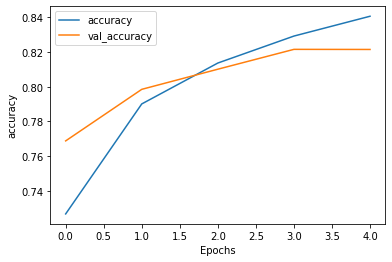

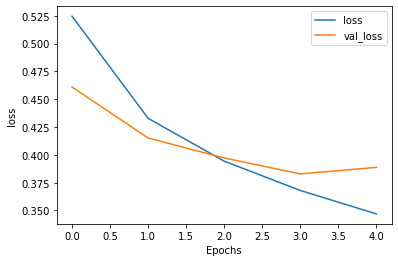

In [ ]:
plot_graphs(history_lstm_base, 'accuracy')
plot_graphs(history_lstm_base, 'loss')

### 예측

In [ ]:
sentence = ['영화 너무 재밌더라.', '영화 개노잼. 다신 안 봐.']
sequence = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequence, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(mecab_lstm_base.predict(padded).round(2))

[[0.46]
 [0.24]]


### 저장

In [ ]:
import json

parameters = {
    'max_len' : 100,
    'pad_type' : 'pre',
    'trunc_type' : 'pre',
}

with open('/content/drive/My Drive/data/nsmc/param_pre.json','w', encoding="utf-8") as make_file:
  json.dump(parameters, make_file, ensure_ascii=False, indent="\t")

In [ ]:
import json

with open("/content/drive/My Drive/data/nsmc/param_pre.json", "r") as st_json:
    st_python = json.load(st_json)

In [ ]:
st_python

{'max_len': 100, 'pad_type': 'pre', 'trunc_type': 'pre'}

In [ ]:
# tokenizer
with open('/content/drive/My Drive/data/nsmc/tokenizer_mecab_pre.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# mecab_lstm_base
mecab_lstm_base.save('/content/drive/My Drive/data/nsmc/model_mecab_lstm_base')

INFO:tensorflow:Assets written to: /content/drive/My Drive/data/nsmc/model_mecab_lstm_base/assets


## Mecab_FastText

In [ ]:
# 임베딩 메트릭스
embedding_matrix = np.zeros((vocab_size , embedding_dim))
# 단어 집합 크기의 행과 100개의 열을 가지는 행렬 생성. 값은 전부 0으로 채워진다.
np.shape(embedding_matrix)
out_index = 0
for word, i in mecab_word_index.items(): # 훈련 데이터의 단어 집합에서 단어를 1개씩 꺼내온다.
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        out_index += 1

print(out_index)

16943


### CNN 모델

In [ ]:
# Kim Yoon CNN
vocab_size = len(mecab_word_index) + 1
embedding_dim = 300
max_len = max(len(x) for x in mecab_training_padded)
class_weights = class_weight.compute_class_weight('balanced', np.unique(training_labels), training_labels)
class_weights_d = dict(enumerate(class_weights))

sequence_input = Input(shape=(max_len,), dtype='int32')

embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                            embedding_dim,
                                            weights=[embedding_matrix],
                                            input_length=max_len,
                                            trainable=False)

embedded_sequences = embedding_layer(sequence_input)

convs = []
filter_sizes = [3,4,5]

for fsz in filter_sizes:
    x = layers.Conv1D(128, fsz, activation='relu',padding='same',kernel_regularizer=l2(1e-3))(embedded_sequences)
    x = layers.MaxPooling1D()(x)
    convs.append(x)
    
x = layers.Concatenate(axis=-1)(convs)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation='sigmoid')(x)


### 컴파일 및 피팅

In [ ]:
model_mecab_ff = keras.models.Model(sequence_input, output)
model_mecab_ff.compile(loss='binary_crossentropy',
                       optimizer='adam',
                       metrics=['accuracy'])

model_mecab_ff.summary()

Model: "functional_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 100, 300)     14984400    input_9[0][0]                    
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 100, 128)     115328      embedding_8[0][0]                
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 100, 128)     153728      embedding_8[0][0]                
______________________________________________________________________________________

In [ ]:
callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0005, patience=1, verbose=0, mode='auto')
# Fit model
history_mecab_ff = model_mecab_ff.fit(mecab_training_padded, training_labels,
                    class_weight = class_weights_d,
                    epochs=10,
                    callbacks=[callback],
                    verbose=True,
                    validation_data=(mecab_testing_padded, testing_labels),
                    batch_size=50)
loss, accuracy = model_mecab_ff.evaluate(mecab_training_padded, training_labels, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_mecab_ff.evaluate(mecab_testing_padded, testing_labels, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/10
3000/3000 [==============================] - 22s 7ms/step - loss: 0.5516 - accuracy: 0.7697 - val_loss: 0.4854 - val_accuracy: 0.7933
Epoch 2/10
3000/3000 [==============================] - 22s 7ms/step - loss: 0.4777 - accuracy: 0.8006 - val_loss: 0.4741 - val_accuracy: 0.7991
Epoch 3/10
4688/4688 [==============================] - 15s 3ms/step - loss: 0.4465 - accuracy: 0.8137
Training Accuracy: 0.8137
Testing Accuracy:  0.7961


### ACC, LOSS 그래프

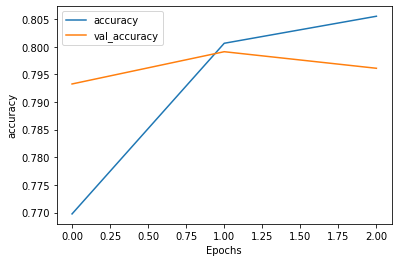

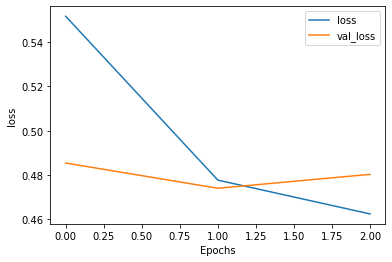

In [ ]:
plot_graphs(history_mecab_ff, 'accuracy')
plot_graphs(history_mecab_ff, 'loss')

### 예측

In [ ]:
sentence = ['영화 너무 재밌더라.', '영화 개노잼. 다신 안 봐.']
sequence = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequence, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model_mecab_ff.predict(padded).round(2))

[[0.59]
 [0.15]]


### LSTM model 

In [ ]:
# Kim Yoon CNN
vocab_size = len(mecab_word_index) + 1
embedding_dim = 300
max_len = max(len(x) for x in mecab_training_padded)
class_weights = class_weight.compute_class_weight('balanced', np.unique(training_labels), training_labels)
class_weights_d = dict(enumerate(class_weights))

sequence_input = Input(shape=(max_len,), dtype='int32')

embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                            embedding_dim,
                                            input_length=max_len,
                                            weights=[embedding_matrix],
                                            trainable=False)

embedded_sequences = embedding_layer(sequence_input)

convs = []
filter_sizes = [3,4,5]

x =layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(embedded_sequences)
x =layers.Bidirectional(tf.keras.layers.LSTM(128))(x)
x =layers.Dense(64, activation='relu')(x)
x =layers.Dropout(0.2)(x)
output = layers.Dense(1, activation='sigmoid')(x)

### 컴파일 및 피팅

In [ ]:
mecab_lstm_fast = keras.models.Model(sequence_input, output)
mecab_lstm_fast.compile(loss='binary_crossentropy',
                       optimizer='adam',
                       metrics=['accuracy'])

mecab_lstm_fast.summary()

Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 100, 300)          14984400  
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 100, 256)          439296    
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 256)               394240    
_________________________________________________________________
dense_18 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)               

In [ ]:
callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0005, patience=2, verbose=0, mode='auto')
mc = ModelCheckpoint('/content/drive/My Drive/data/nsmc/lstm_fast_best', monitor='val_loss', mode='min', save_best_only=True)

# Fit model
history_lstm_fast = mecab_lstm_fast.fit(mecab_training_padded, training_labels,
                    class_weight = class_weights_d,
                    epochs=10,
                    callbacks=[callback,mc],
                    verbose=True,
                    validation_data=(mecab_testing_padded, testing_labels),
                    batch_size=50)
loss, accuracy = mecab_lstm_fast.evaluate(mecab_training_padded, training_labels, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = mecab_lstm_fast.evaluate(mecab_testing_padded, testing_labels, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/10
3000/3000 [==============================] - 111s 37ms/step - loss: 0.4619 - accuracy: 0.7758 - val_loss: 0.4129 - val_accuracy: 0.8089
Epoch 2/10
3000/3000 [==============================] - 110s 37ms/step - loss: 0.3806 - accuracy: 0.8254 - val_loss: 0.3767 - val_accuracy: 0.8287
Epoch 3/10
3000/3000 [==============================] - 111s 37ms/step - loss: 0.3448 - accuracy: 0.8453 - val_loss: 0.3618 - val_accuracy: 0.8350
Epoch 4/10
3000/3000 [==============================] - 111s 37ms/step - loss: 0.3138 - accuracy: 0.8595 - val_loss: 0.3592 - val_accuracy: 0.8402
Epoch 5/10
3000/3000 [==============================] - 92s 31ms/step - loss: 0.2798 - accuracy: 0.8759 - val_loss: 0.3663 - val_accuracy: 0.8354
Epoch 6/10
4688/4688 [==============================] - 44s 9ms/step - loss: 0.2008 - accuracy: 0.9156
Training Accuracy: 0.9156
Testing Accuracy:  0.8352


### ACC, LOSS 그래프

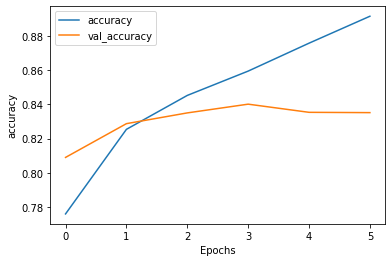

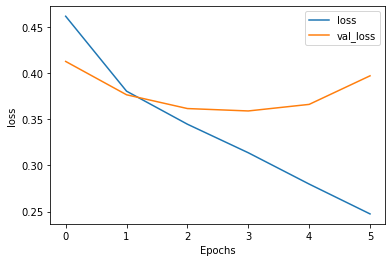

In [ ]:
plot_graphs(history_lstm_fast, 'accuracy')
plot_graphs(history_lstm_fast, 'loss')

### 예측

In [ ]:
sentence = ['영화 너무 재밌더라.', '영화 개노잼. 다신 안 봐.']
sequence = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequence, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(mecab_lstm_fast.predict(padded).round(2))

[[0.31]
 [0.48]]


### 저장

In [ ]:
# mecab_lstm_fast
mecab_lstm_fast.save('/content/drive/My Drive/data/nsmc/model_mecab_lstm_fast')

INFO:tensorflow:Assets written to: /content/drive/My Drive/data/nsmc/model_mecab_lstm_fast/assets


## Mecab_Word2Vec

In [ ]:
token_list=mecab_nizer(full_sentences)

In [ ]:
word2vec = Word2Vec(
    sentences = token_list,
    size = embedding_dim,
    alpha = 0.025,
    min_count = 1,
    window=8,
    sample = 0.001,
    sg = 1,
    iter = 10
)

In [ ]:
# 임베딩 메트릭스
embedding_matrix = np.zeros((vocab_size , embedding_dim))
# 단어 집합 크기의 행과 100개의 열을 가지는 행렬 생성. 값은 전부 0으로 채워진다.
np.shape(embedding_matrix)
out_index = 0
for word, i in mecab_word_index.items(): # 훈련 데이터의 단어 집합에서 단어를 1개씩 꺼내온다.
  try:
    embedding_vector = word2vec.wv.__getitem__(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        out_index += 1
  except:
    out_index +=1

print(out_index)

48021


### CNN 모델

In [ ]:
# Kim Yoon CNN
vocab_size = len(mecab_word_index) + 1
embedding_dim = 300
max_len = max(len(x) for x in mecab_training_padded)
class_weights = class_weight.compute_class_weight('balanced', np.unique(training_labels), training_labels)
class_weights_d = dict(enumerate(class_weights))

sequence_input = Input(shape=(max_len,), dtype='int32')

embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                            embedding_dim,
                                            weights=[embedding_matrix],
                                            input_length=max_len,
                                            trainable=False)

embedded_sequences = embedding_layer(sequence_input)

convs = []
filter_sizes = [3,4,5]

for fsz in filter_sizes:
    x = layers.Conv1D(128, fsz, activation='relu',padding='same',kernel_regularizer=l2(1e-3))(embedded_sequences)
    x = layers.MaxPooling1D()(x)
    convs.append(x)
    
x = layers.Concatenate(axis=-1)(convs)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation='sigmoid')(x)


### 컴파일 및 피팅

In [ ]:
model_mecab_w2 = keras.models.Model(sequence_input, output)
model_mecab_w2.compile(loss='binary_crossentropy',
                       optimizer='adam',
                       metrics=['accuracy'])

model_mecab_w2.summary()

Model: "functional_29"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 100, 300)     14984400    input_11[0][0]                   
__________________________________________________________________________________________________
conv1d_12 (Conv1D)              (None, 100, 128)     115328      embedding_10[0][0]               
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, 100, 128)     153728      embedding_10[0][0]               
______________________________________________________________________________________

In [ ]:
callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0005, patience=1, verbose=0, mode='auto')
# Fit model
history_mecab_w2 = model_mecab_w2.fit(mecab_training_padded, training_labels,
                    class_weight = class_weights_d,
                    epochs=10,
                    callbacks=[callback],
                    verbose=True,
                    validation_data=(mecab_testing_padded, testing_labels),
                    batch_size=50)
loss, accuracy = model_mecab_w2.evaluate(mecab_training_padded, training_labels, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_mecab_w2.evaluate(mecab_testing_padded, testing_labels, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/10
3000/3000 [==============================] - 22s 7ms/step - loss: 0.6202 - accuracy: 0.6853 - val_loss: 0.5954 - val_accuracy: 0.6956
Epoch 2/10
3000/3000 [==============================] - 22s 7ms/step - loss: 0.5823 - accuracy: 0.7043 - val_loss: 0.5771 - val_accuracy: 0.7053
Epoch 3/10
3000/3000 [==============================] - 22s 7ms/step - loss: 0.5720 - accuracy: 0.7088 - val_loss: 0.5762 - val_accuracy: 0.7040
Epoch 4/10
4688/4688 [==============================] - 15s 3ms/step - loss: 0.5543 - accuracy: 0.7161
Training Accuracy: 0.7161
Testing Accuracy:  0.7017


### ACC, LOSS 그래프

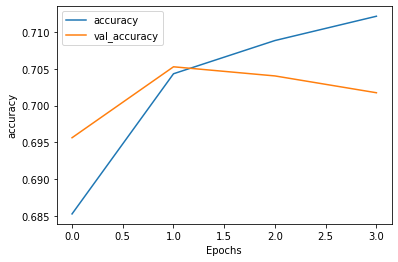

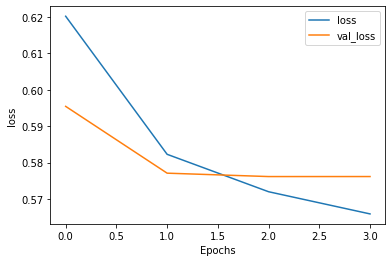

In [ ]:
plot_graphs(history_mecab_w2, 'accuracy')
plot_graphs(history_mecab_w2, 'loss')

### 예측

In [ ]:
sentence = ['영화 너무 재밌더라.', '영화 개노잼. 다신 안 봐.']
sequence = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequence, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model_mecab_w2.predict(padded).round(2))

[[0.52]
 [0.12]]


### LSTM model 

In [ ]:
# Kim Yoon CNN
vocab_size = len(mecab_word_index) + 1
embedding_dim = 300
max_len = max(len(x) for x in mecab_training_padded)
class_weights = class_weight.compute_class_weight('balanced', np.unique(training_labels), training_labels)
class_weights_d = dict(enumerate(class_weights))

sequence_input = Input(shape=(max_len,), dtype='int32')

embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                            embedding_dim,
                                            input_length=max_len,
                                            weights=[embedding_matrix],
                                            trainable=False)

embedded_sequences = embedding_layer(sequence_input)

convs = []
filter_sizes = [3,4,5]

x =layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(embedded_sequences)
x =layers.Bidirectional(tf.keras.layers.LSTM(128))(x)
x =layers.Dense(64, activation='relu')(x)
x =layers.Dropout(0.2)(x)
output = layers.Dense(1, activation='sigmoid')(x)

### 컴파일 및 피팅

In [ ]:
mecab_lstm_word = keras.models.Model(sequence_input, output)
mecab_lstm_word.compile(loss='binary_crossentropy',
                       optimizer='adam',
                       metrics=['accuracy'])

mecab_lstm_word.summary()

Model: "functional_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
embedding_11 (Embedding)     (None, 100, 300)          14984400  
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 100, 256)          439296    
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 256)               394240    
_________________________________________________________________
dense_22 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)               

In [ ]:
callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0005, patience=2, verbose=0, mode='auto')
mc = ModelCheckpoint('/content/drive/My Drive/data/nsmc/lstm_word_best', monitor='val_loss', mode='min', save_best_only=True)

# Fit model
history_lstm_word = mecab_lstm_word.fit(mecab_training_padded, training_labels,
                    class_weight = class_weights_d,
                    epochs=10,
                    callbacks=[callback,mc],
                    verbose=True,
                    validation_data=(mecab_testing_padded, testing_labels),
                    batch_size=50)
loss, accuracy = mecab_lstm_word.evaluate(mecab_training_padded, training_labels, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = mecab_lstm_word.evaluate(mecab_testing_padded, testing_labels, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/10
3000/3000 [==============================] - 109s 36ms/step - loss: 0.5792 - accuracy: 0.6817 - val_loss: 0.5549 - val_accuracy: 0.6997
Epoch 2/10
3000/3000 [==============================] - 108s 36ms/step - loss: 0.5423 - accuracy: 0.7098 - val_loss: 0.5359 - val_accuracy: 0.7083
Epoch 3/10
3000/3000 [==============================] - 110s 37ms/step - loss: 0.5226 - accuracy: 0.7237 - val_loss: 0.5290 - val_accuracy: 0.7209
Epoch 4/10
3000/3000 [==============================] - 89s 30ms/step - loss: 0.5061 - accuracy: 0.7350 - val_loss: 0.5305 - val_accuracy: 0.7182
Epoch 5/10
3000/3000 [==============================] - 109s 36ms/step - loss: 0.4910 - accuracy: 0.7443 - val_loss: 0.5246 - val_accuracy: 0.7235
Epoch 6/10
3000/3000 [==============================] - 109s 36ms/step - loss: 0.4744 - accuracy: 0.7545 - val_loss: 0.5197 - val_accuracy: 0.7273
Epoch 7/10
3000/3000 [==============================] - 89s 30ms/step - loss: 0.4554 - accuracy: 0.7658 - val_loss: 0.5

### ACC, LOSS 그래프

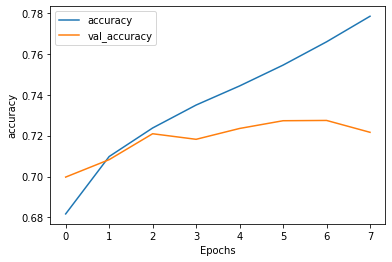

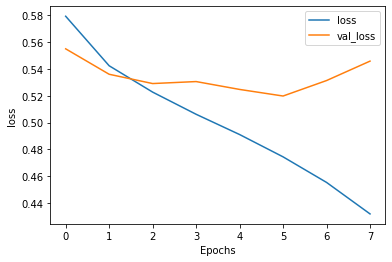

In [ ]:
plot_graphs(history_lstm_word, 'accuracy')
plot_graphs(history_lstm_word, 'loss')

### 예측

In [ ]:
sentence = ['영화 너무 재밌더라.', '영화 개노잼. 다신 안 봐.']
sequence = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequence, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(mecab_lstm_word.predict(padded).round(2))

[[0.53]
 [0.06]]


### 저장

In [ ]:
# mecab_lstm_fast
mecab_lstm_word.save('/content/drive/My Drive/data/nsmc/model_mecab_lstm_word')

INFO:tensorflow:Assets written to: /content/drive/My Drive/data/nsmc/model_mecab_lstm_word/assets


In [ ]:
model_mecab_base.save('/content/drive/My Drive/data/nsmc/model_mecab_cnn_base')
model_mecab_ff.save('/content/drive/My Drive/data/nsmc/model_mecab_cnn_fast')
model_mecab_w2.save('/content/drive/My Drive/data/nsmc/model_mecab_cnn_word')

INFO:tensorflow:Assets written to: /content/drive/My Drive/data/nsmc/model_mecab_cnn_base/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/nsmc/model_mecab_cnn_fast/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/nsmc/model_mecab_cnn_word/assets
